<body>
<h2>Project 5: Bias Variance Trade-Off</h2>

<!--announcements-->
<blockquote>
    <center>
    <a href="http://blogs.worldbank.org/publicsphere/files/publicsphere/biased_processing.jpg"><img src="bias.jpg" width="600px" /></a>
    </center>
      <p><cite><center>"All of us show bias when it comes to what information we take in.<br>We typically focus on anything that agrees with the outcome we want."<br>
<b>--Noreena Hertz</b>
      </center></cite></p>
</blockquote>
<h3>Introduction</h3>

<p>
Recall that the squared error can be decomposed into <em>bias</em>, <em>variance</em> and <em>noise</em>: 
$$
    \underbrace{\mathbb{E}[(h_D(x) - y)^2]}_\mathrm{Error} = \underbrace{\mathbb{E}[(h_D(x)-\bar{h}(x))^2]}_\mathrm{Variance} + \underbrace{\mathbb{E}[(\bar{h}(x)-\bar{y}(x))^2]}_\mathrm{Bias} + \underbrace{\mathbb{E}[(\bar{y}(x)-y(x))^2]}_\mathrm{Noise}\nonumber
$$
We will now create a data set for which we can approximately compute this decomposition. 
The function <em><strong>`toydata`</strong></em> generates a binary data set with class $1$ and $2$. Both are sampled from Gaussian distributions:
$$
p(\vec x|y=1)\sim {\mathcal{N}}(0,{I}) \textrm { and } p(\vec x|y=2)\sim {\mathcal{N}}(\mu_2,{I}),
$$

where $\mu_2=[2;2]^\top$ (the global variable <em>OFFSET</em> $\!=\!2$ regulates these values: $\mu_2=[$<em>OFFSET</em> $;$ <em>OFFSET</em>$]^\top$).
</p>

<h3>Computing noise, bias and variance</h3>
<p>
You will need to edit three functions:  <em><strong>`computeybar`</strong></em>,  <em><strong>`computehbar`</strong></em>, and <em><strong>`computevariance`</strong></em>. First take a look at <strong>`biasvariancedemo`</strong> and make sure you understand where each function should be called and how they contribute to the Bias/Variance/Noise decomposition. <br/><br/>
</p>

**Libraries**: Before we get started we need to install a few libraries. You can do this by executing the following code.

In [1]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
#</GRADED>

In [2]:
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt
import sys
from scipy.io import loadmat
import time

%matplotlib notebook

**`l2distance` Helper Function**: `l2distance` is a helper function used in our implementation of the ridge regression.

In [3]:
#<GRADED>

In [4]:
def l2distance(X, Z=None):
    """
    function D=l2distance(X,Z)

    Computes the Euclidean distance matrix.
    Syntax:
    D=l2distance(X,Z)
    Input:
    X: (d, n) data matrix with n vectors (columns) of dimensionality d
    Z: (d, m) data matrix with m vectors (columns) of dimensionality d

    Output:
    Matrix D of size (n, m)
    D(i,j) is the Euclidean distance of X(:,i) and Z(:,j)

    call with only one input:
    l2distance(X)=l2distance(X,X)
    """
    if Z is None:
        n, d = X.shape
        s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
        D1 = -2 * np.dot(X, X.T) + repmat(s1, 1, n)
        D = D1 + repmat(s1.T, n, 1)
        np.fill_diagonal(D, 0)
        D = np.sqrt(np.maximum(D, 0))
    else:
        n, d = X.shape
        m, _ = Z.shape
        s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
        s2 = np.sum(np.power(Z, 2), axis=1).reshape(1,-1)
        D1 = -2 * np.dot(X, Z.T) + repmat(s1, 1, m)
        D = D1 + repmat(s2, n, 1)
        D = np.sqrt(np.maximum(D, 0))
    return D


In [5]:
#</GRADED>

**`toydata` Helper Function**: `toydata` is a helper function used to generate the the binary data with $\frac n 2$ values in class 1 and $\frac n 2$ values in class 2, with class 1 being the label for data drawn from a normal distribution with mean $\mu = 0$ and stdev $\sigma = 1$, and class 2 being the label for data drawn from a normal distribution with mean $\mu = \text{OFFSET}$ and stdev $\sigma = 1$.

In [6]:
#<GRADED>

In [7]:
def toydata(OFFSET,N):
    """
    function [x,y]=toydata(OFFSET,N)
    
    This function constructs a binary data set. 
    Each class is distributed by a standard Gaussian distribution.
    INPUT: 
    OFFSET:  Class 1 has mean 0,  class 2 has mean 0+OFFSET (in each dimension). Both have stdev 1.
    N: The function returns N data points; half are class 1, half are class 2.
    """
    
    NHALF = int(np.ceil(N/2))
    x = np.random.randn(N, 2)
    x[NHALF:, :] += OFFSET  
    
    y = np.ones(N)
    y[NHALF:] *= 2
    
    jj = np.random.permutation(N)
    return x[jj, :], y[jj]

In [8]:
#</GRADED>

<p>
(a) <strong>Noise:</strong> First we focus on the noise. For this, you need to compute $\bar y(\vec x)$ in  <em><strong>`computeybar`</strong></em>. You can compute the probability $p(\vec x|y)$ with the equations $p(\vec x|y=1)\sim {\mathcal{N}}(0,{I}) \textrm { and } p(\vec x|y=2)\sim {\mathcal{N}}(\mu_2,{I})$. Then use Bayes rule to compute $p(y|\vec x)$. <br/><br/>
<strong>Note:</strong> You may want to use the function <em>`normpdf`</em>, which is defined for  you in <em><strong>`computeybar`</strong></em>.


<h2>The expected label is not the most likely label! The expected label is $1 \cdot p(y = 1 \mid x) + 2 \cdot p(y=2 \mid x)$</h2>
<br/><br/></p>


In [9]:
#<GRADED>

In [10]:
def computeybar(xTe, OFFSET):
    """
    function [ybar]=computeybar(xTe, OFFSET);

    computes the expected label 'ybar' for a set of inputs x
    generated from two standard normal distributions (one offset by OFFSET in
    both dimensions.)
    
    INPUT:
    xTe : (n, 2) array of n vectors with 2 dimensions
    OFFSET    : The OFFSET passed into the toyData function. The difference in the
                mu of labels class1 and class2 for toyData.

    OUTPUT:
    ybar : a (n,) vector of the expected labels for vectors xTe
    """
    n,temp = xTe.shape
    ybar = np.zeros(n)
    
    # Feel free to use the following function to compute p(x|y), or not
    # normal distribution is default mu = 0, sigma = 1.
    normpdf = lambda x, mu, sigma: np.exp(-0.5 * np.power((x - mu) / sigma, 2)) / (np.sqrt(2 * np.pi) * sigma)
    
    ## fill in code here
    for i in range(n):
        # First Calculate p(x|y1) and p(x|y2) 
        px_y1 = normpdf(xTe[i, 0], 0, 1) * normpdf(xTe[i, 1], 0, 1)
        px_y2 = normpdf(xTe[i, 0], OFFSET, 1) * normpdf(xTe[i, 1], OFFSET, 1)
        
        # By defintion, we split the data into halves, hence p(y1) = p(y2) = .5
        py1 = py2 = 0.5
        
        # The Law of total probability: p(x) = p(x U y1) + p(x U y2)
        px = px_y1 * py1 + px_y2 * py2
        
        # Use Bayes Rule to Compute p(y1|x) and p(y2|x)
        py1_x = px_y1 * py1 / px
        py2_x = px_y2 * py2 / px
    
        # Compute ybar using definition
        ybar[i] = 1 * py1_x + 2 * py2_x
    return ybar

In [11]:
#</GRADED>

**Visualizing the Data**:
You can now see the error of the bayes classifier. Below is a plotting of the two classes of points and the misclassified points.

Error of Bayes classifier: 8.7%.


<IPython.core.display.Javascript object>


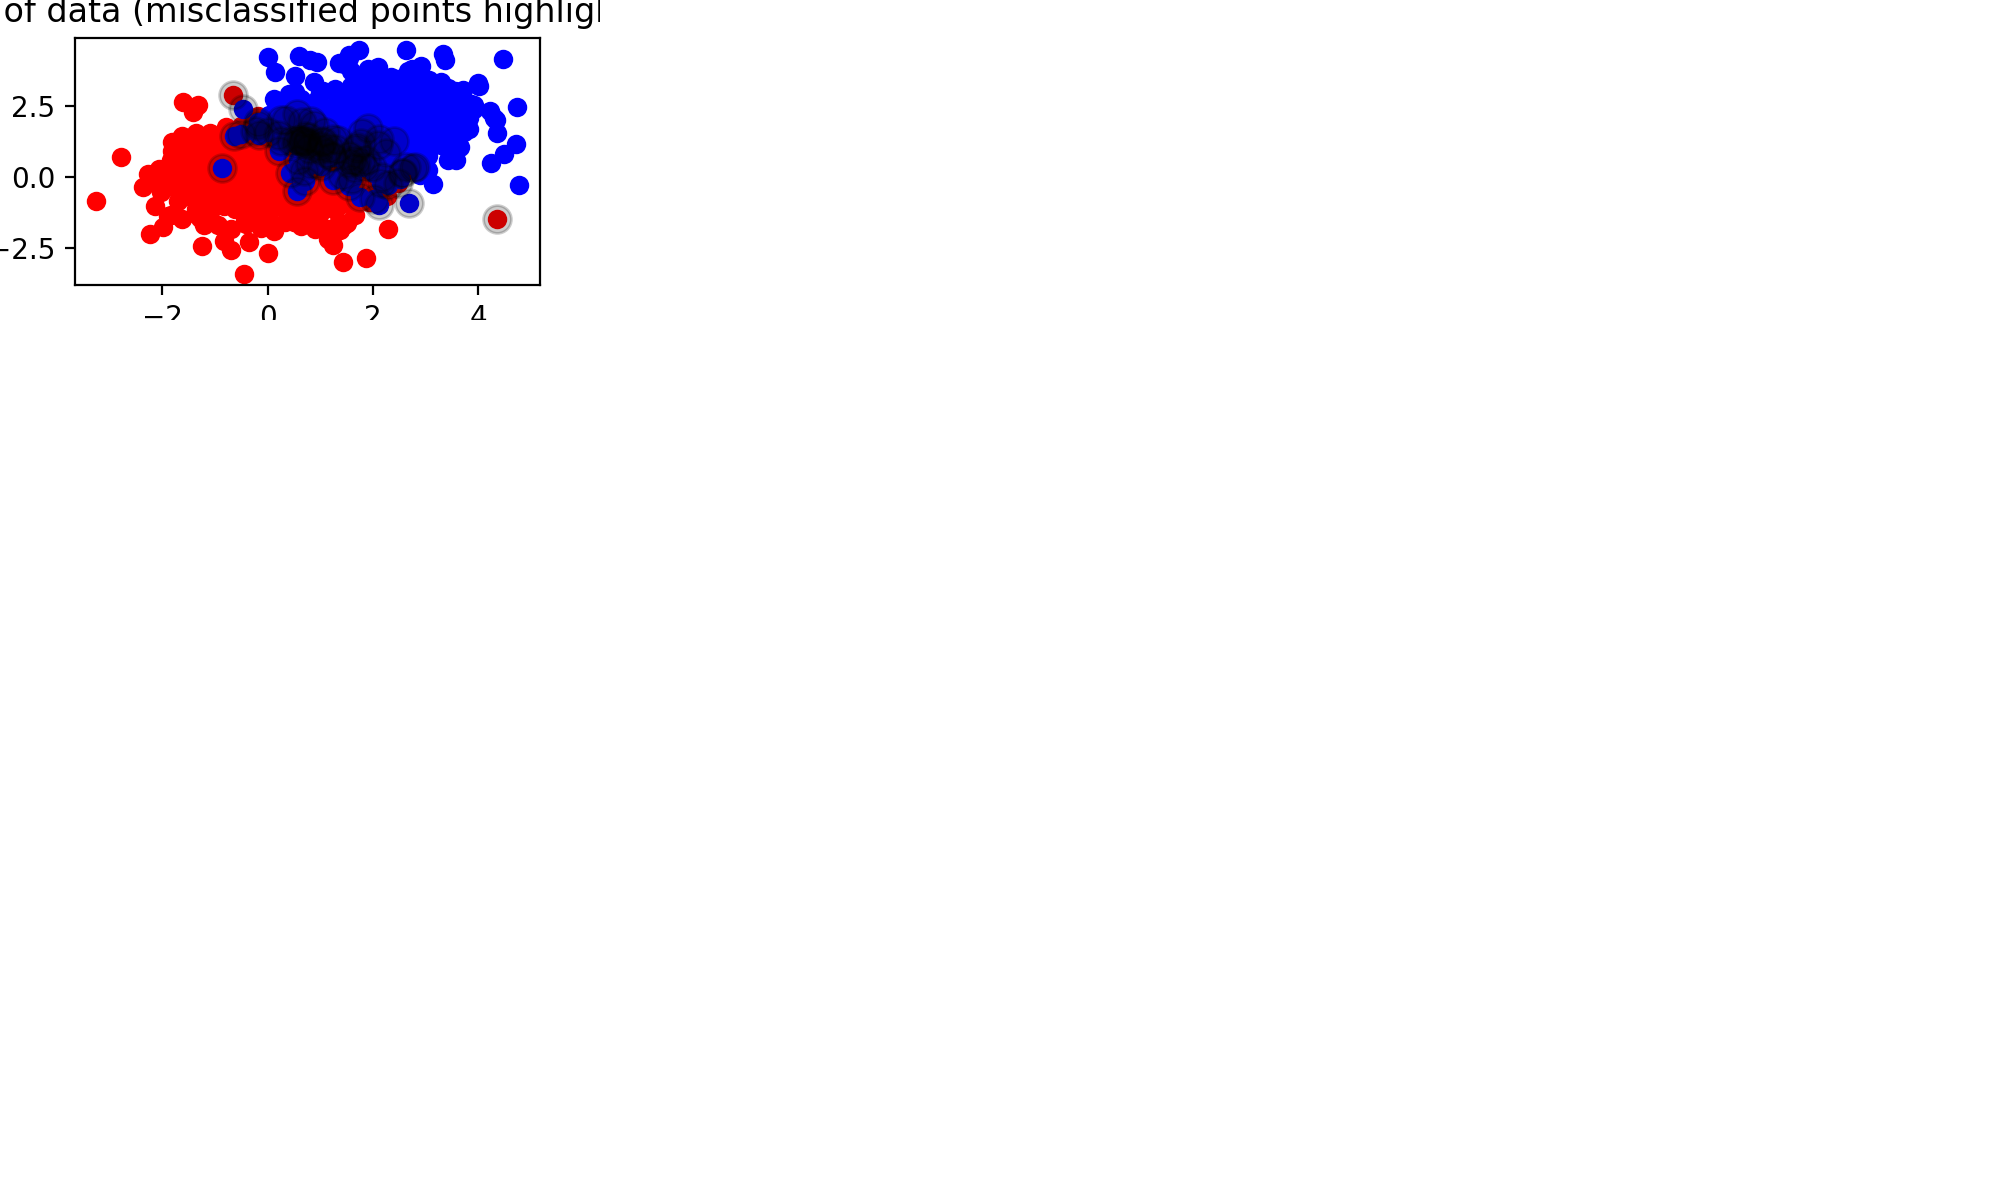

In [12]:
OFFSET = 2
xTe, yTe = toydata(OFFSET, 1000)

# compute Bayes Error
ybar = computeybar(xTe, OFFSET)
predictions = np.round(ybar)
errors = predictions != yTe
err = errors.sum() / len(yTe) * 100
print('Error of Bayes classifier: %.1f%%.' % err)

# plot data
i1 = yTe == 1
i2 = yTe == 2
plt.figure(figsize=(10,6))
plt.scatter(xTe[i1, 0], xTe[i1, 1], c='r', marker='o')
plt.scatter(xTe[i2, 0], xTe[i2, 1], c='b', marker='o')
plt.scatter(xTe[errors, 0], xTe[errors, 1], c='k', s=100, alpha=0.2)
plt.title("Plot of data (misclassified points highlighted)")
plt.show()

<p>With the help of <strong>`computeybar`</strong> you can now compute the "noise" variable within <strong>`biasvariancedemo`</strong>. </p>

**`kregression` Helper Function**: 
<br/>
<strong>Important</strong> - $h_D$ is defined for you in <em><strong>`kregression`</strong></em>. It's kernelized ridge regression with kernel width $\sigma$ and regularization constant $\lambda$.
<br/><br/>

In [13]:
#<GRADED>

In [14]:
def kregression(xTr,yTr,sigma=0.1,lmbda=0.01):
    """
    function kregression(xTr,yTr,sigma,lmbda)
    
    Input:
    xTr   | training data (n, 2)
    yTr   | training labels (n,)
    sigma | kernel width (>0)
    lmbda | regularization constant (>0)
    
    Output:
    fun   | usage: predictions=fun(xTe)
    """
    kernel = lambda x, z: np.power(1+(np.power(l2distance(x,z),2) / (2 * np.power(sigma,2))),-4)
    ridge = lambda K, lmbda2: K + lmbda * np.eye(K.shape[0], K.shape[1])
    beta = np.linalg.solve(ridge(kernel(xTr, xTr), lmbda), yTr)
    
    fun = lambda Xt: np.dot(kernel(Xt, xTr), beta)
    return fun

In [15]:
#</GRADED>

<p>
(b) <strong>Bias:</strong> For the bias, you will need $\bar{h}$. Although we cannot compute the expected value  $\bar h\!=\!\mathbb{E}[h]$, we can approximate it by training many $h_D$ and averaging their predictions. Edit the file <em><strong>`computehbar`</strong></em>. Average over <em>NMODELS</em> different $h_D$, each trained on a different data set of <em>Nsmall</em> inputs drawn from the same distribution. Feel free to call <em><strong>`toydata`</strong></em> to obtain more data sets. <br/><br/>
</p>

In [16]:
#<GRADED>

In [17]:
def computehbar(xTe, sigma, lmbda, Nsmall, NMODELS, OFFSET):
    """
    function [hbar]=computehbar(xTe, sigma, lmbda, NSmall, NMODELS, OFFSET);

    computes the expected prediction of the average classifier (hbar)
    for data set xTe. 

    The training data of size Nsmall is drawn from toydata with OFFSET 
    with kernel regression with sigma and lmbda

    The "infinite" number of models is estimated as an average over NMODELS. 

    INPUT:
    xTe       | (n, 2) matrix, of n column-wise input vectors (each 2-dimensional)
    sigma     | kernel width of the RBF kernel
    lmbda     | regularization constant
    NSmall    | Number of points to subsample
    NMODELS   | Number of Models to average over
    OFFSET    | The OFFSET passed into the toyData function. The difference in the
                mu of labels class1 and class2 for toyData.
    OUTPUT:
    hbar | (n,) vector with the predictions of hbar for each test input
    """
    n = xTe.shape[0]
    hbar = np.zeros(n)
    for j in range(NMODELS):
        # Use toydata to generate training data of size Nsmall
        xTr, yTr = toydata(OFFSET, Nsmall)
        
        # Use kregression to train a model and make predictions on xTe
        pred = (kregression(xTr, yTr, sigma, lmbda))(xTe)
                
        # Update hbar
        hbar += pred
    hbar /= NMODELS
    return hbar

In [18]:
#</GRADED>

<p>With the help of <strong>`computehbar`</strong> you can now compute the "bias" variable within <strong>`biasvariancedemo`</strong>. </p>


<p>(c) <strong>Variance:</strong> Finally, to compute the variance, we need to compute the term $\mathbb{E}[(h_D-\bar{h})^2]$. Once again, we can approximate this term by averaging over  <em>NMODELS</em> models. Edit the file <em><strong>`computevariance`</strong></em>. 
<br/></br></p>

In [19]:
#<GRADED>

In [20]:
def computevariance(xTe, sigma, lmbda, hbar, Nsmall, NMODELS, OFFSET):
    """
    function variance=computevariance(xTe,sigma,lmbda,hbar,Nsmall,NMODELS,OFFSET)

    computes the variance of classifiers trained on data sets from
    toydata.m with pre-specified "OFFSET" and 
    with kernel regression with sigma and lmbda
    evaluated on xTe. 
    the prediction of the average classifier is assumed to be stored in "hbar".

    The "infinite" number of models is estimated as an average over NMODELS. 

    INPUT:
    xTe       : (n, 2) matrix, of n column-wise input vectors (each 2-dimensional)
    sigma     : kernel width of the RBF kernel
    lmbda     : regularization constant
    hbar      : nx1 vector of the predictions of hbar on the inputs xTe
    Nsmall    : Number of samples drawn from toyData for one model
    NMODELS   : Number of Models to average over
    OFFSET    : The OFFSET passed into the toyData function. The difference in the
                mu of labels class1 and class2 for toyData.
    """
    n = xTe.shape[0]
    variance = np.zeros(n)
    
    for j in range(NMODELS):
        ## fill in code here
        xTr, yTr = toydata(OFFSET, Nsmall)
        pred = (kregression(xTr, yTr, sigma, lmbda))(xTe)
        variance += np.square(pred - hbar)
    
    variance = np.mean(variance)/NMODELS
    return variance

In [21]:
#</GRADED>

<p>With the help of <strong>`computevariance`</strong> you can now compute the "variance" variable within <strong>`biasvariancedemo`</strong>. </p>

<p>If you did everything correctly and call execute the following demo. You should see how the error decomposes (roughly) into bias, variance and noise when regularization constant $\lambda$ increases.</p>
<br/>

In [22]:
# biasvariancedemo

# how big is the training set size N
Nsmall = 10
# how big is a really big data set (approx. infinity)
Nbig = 10000
# how many models do you want to average over
NMODELS = 100
# What regularization constants to evaluate
lmbdas = np.arange(-6, 0+0.5, 0.5)
# what is the kernel width?
sigma = 4

# we store
Nlambdas = len(lmbdas)
lbias = np.zeros(Nlambdas)
lvariance = np.zeros(Nlambdas)
ltotal = np.zeros(Nlambdas)
lnoise = np.zeros(Nlambdas)
lsum = np.zeros(Nlambdas)

# Different regularization constant classifiers
for md in range(Nlambdas):
    lmbda = 2 ** lmbdas[md]
    # use this data set as an approximation of the true test set
    xTe,yTe = toydata(OFFSET,Nbig)
    
    # Estimate AVERAGE ERROR (TOTAL)
    total = 0
    for j in range(NMODELS):
        xTr2,yTr2 = toydata(OFFSET,Nsmall)
        fsmall = kregression(xTr2,yTr2,sigma,lmbda)
        total += np.mean((fsmall(xTe) - yTe) ** 2)
    total /= NMODELS
    
    # Estimate Noise
    ybar = computeybar(xTe, OFFSET)
    noise = np.mean((yTe-ybar) ** 2)
    
    # Estimate Bias
    hbar = computehbar(xTe,sigma, lmbda, Nsmall, NMODELS, OFFSET)
    bias = np.mean((hbar-ybar) ** 2)
    
    # Estimating VARIANCE
    variance = computevariance(xTe,sigma,lmbda,hbar, Nsmall, NMODELS, OFFSET)
    
    # print and store results
    lbias[md] = bias
    lvariance[md] = variance
    ltotal[md] = total
    lnoise[md] = noise
    lsum[md] = lbias[md]+lvariance[md]+lnoise[md]
    print('Regularization λ=2^%2.1f: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (lmbdas[md],lbias[md],lvariance[md],lnoise[md],lsum[md],ltotal[md]))

Regularization λ=2^-6.0: Bias: 0.0257 Variance: 0.0696 Noise: 0.0584 Bias+Variance+Noise: 0.1537 Test error: 0.1666
Regularization λ=2^-5.5: Bias: 0.0274 Variance: 0.0754 Noise: 0.0561 Bias+Variance+Noise: 0.1589 Test error: 0.1481
Regularization λ=2^-5.0: Bias: 0.0325 Variance: 0.0593 Noise: 0.0597 Bias+Variance+Noise: 0.1515 Test error: 0.1406
Regularization λ=2^-4.5: Bias: 0.0333 Variance: 0.0599 Noise: 0.0602 Bias+Variance+Noise: 0.1534 Test error: 0.1429
Regularization λ=2^-4.0: Bias: 0.0388 Variance: 0.0544 Noise: 0.0607 Bias+Variance+Noise: 0.1539 Test error: 0.1506
Regularization λ=2^-3.5: Bias: 0.0424 Variance: 0.0408 Noise: 0.0583 Bias+Variance+Noise: 0.1415 Test error: 0.1441
Regularization λ=2^-3.0: Bias: 0.0474 Variance: 0.0438 Noise: 0.0587 Bias+Variance+Noise: 0.1499 Test error: 0.1428
Regularization λ=2^-2.5: Bias: 0.0524 Variance: 0.0362 Noise: 0.0574 Bias+Variance+Noise: 0.1460 Test error: 0.1384
Regularization λ=2^-2.0: Bias: 0.0592 Variance: 0.0327 Noise: 0.0570 Bia

<IPython.core.display.Javascript object>


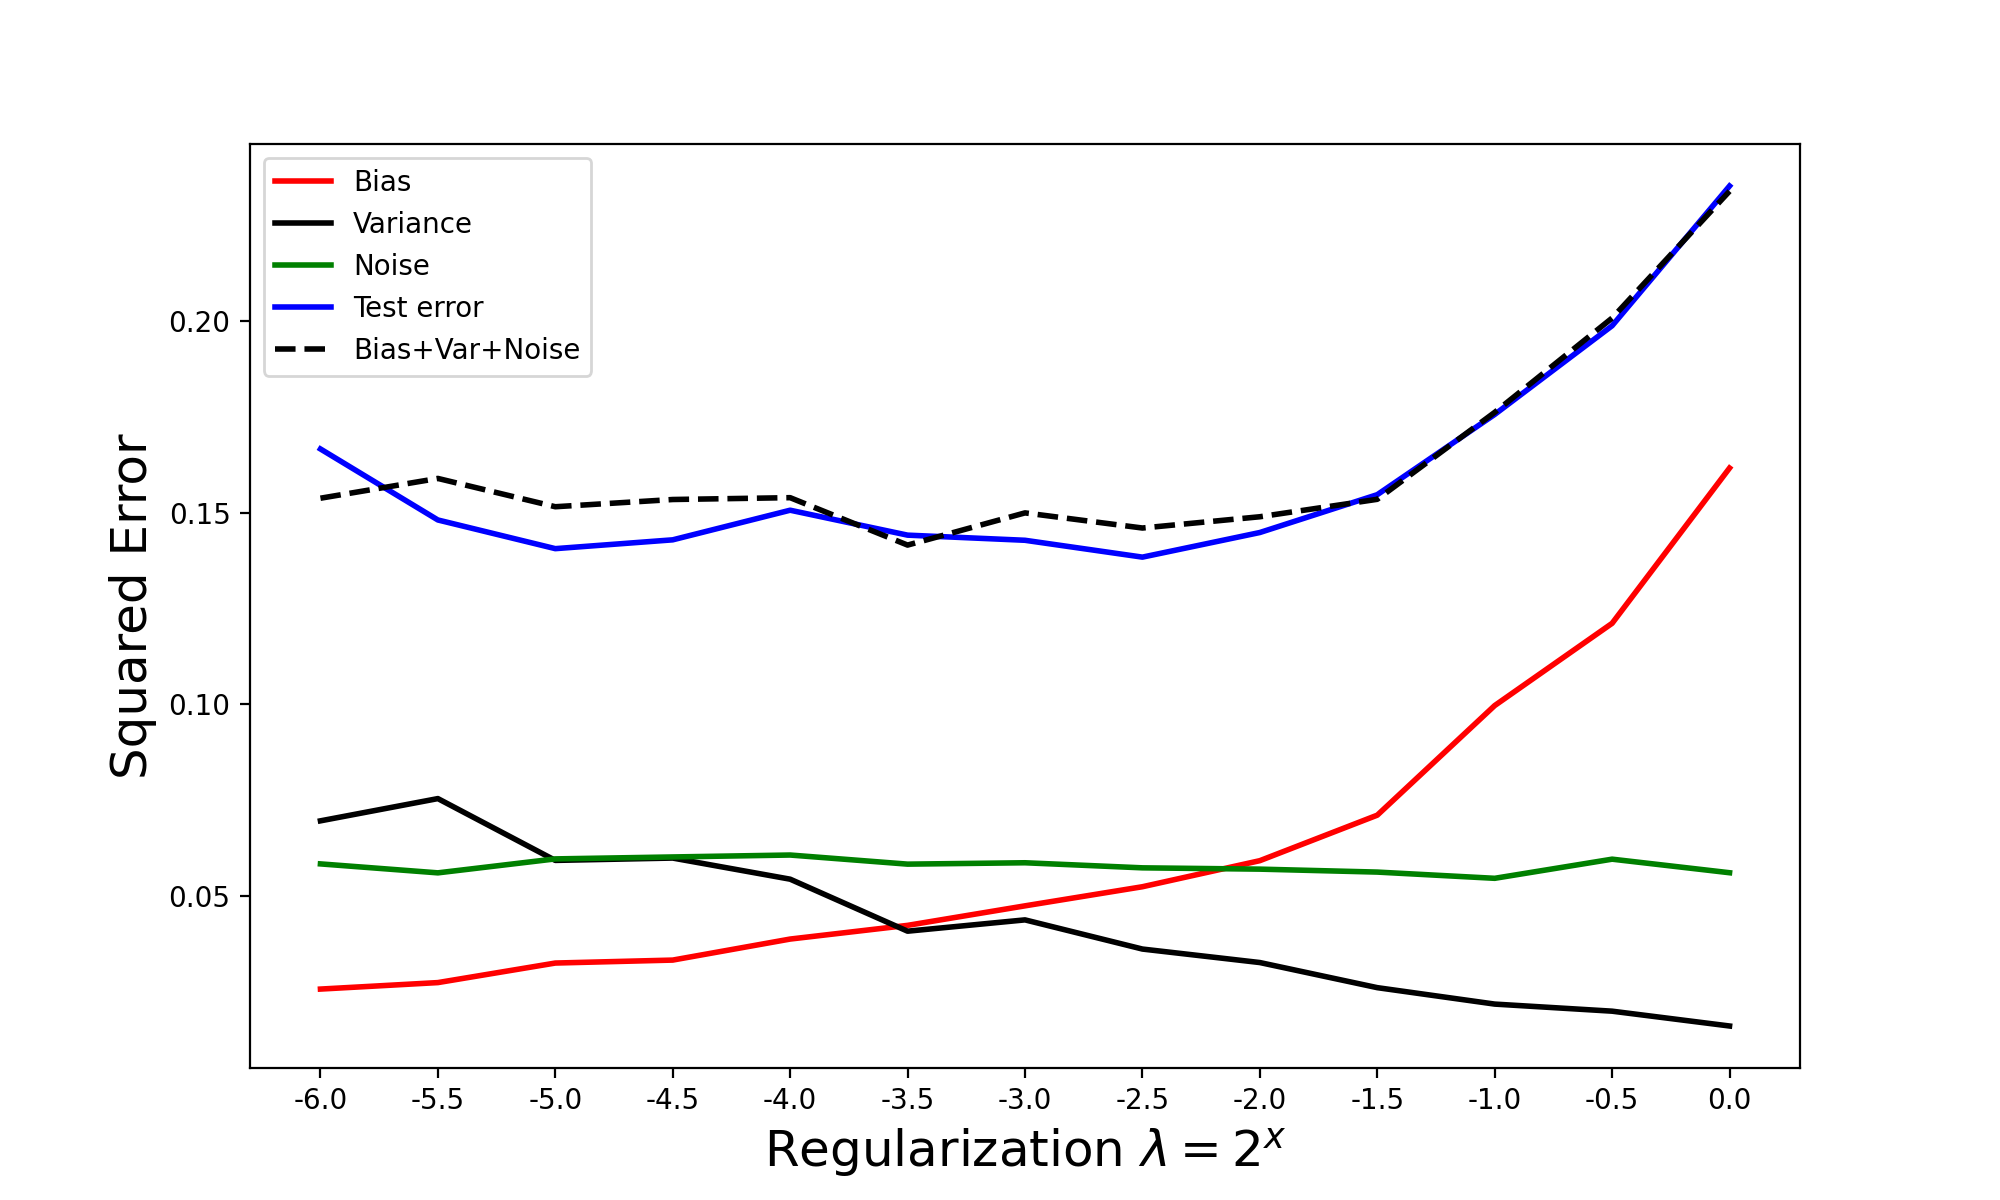

In [23]:
# plot results
plt.figure(figsize=(10,6))
plt.plot(lbias[:Nlambdas],c='r',linestyle='-',linewidth=2)
plt.plot(lvariance[:Nlambdas],c='k', linestyle='-',linewidth=2)
plt.plot(lnoise[:Nlambdas],c='g', linestyle='-',linewidth=2)
plt.plot(ltotal[:Nlambdas],c='b', linestyle='-',linewidth=2)
plt.plot(lsum[:Nlambdas],c='k', linestyle='--',linewidth=2)

plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"]);
plt.xlabel("Regularization $\lambda=2^x$",fontsize=18);
plt.ylabel("Squared Error",fontsize=18);
plt.xticks([i for i in range(Nlambdas)],lmbdas);

Feel free to modify $\lambda$/$\sigma$ in these two files. If you want the approximation to be more accurate, increase <em>NMODELS</em> and/or <em>Nbig</em> (the more models you train, the better your approximation will be for $\mathbb{E}[h]$ and $\mathbb{E}[(h_D-\bar{h})^2]$). 
You can also play around with the variable <em>Nsmall</em> which regulates how big your actual training is supposed to be. 
</p>


<h3>Note</h3>
<p>
When computing the bias and variance, you approximate the results by training many $h_D$. We set <em>NMODELS</em>=1000 and use some thresholds to test if your functions' results are correct. Unfortunately, as a result of this randomness, there is still a small chance that you will fail some test cases, even though your implementations are correct. <br/><br/>
If you can pass all the tests most of the times locally, then you are fine. In this case, if the autograder says your accuracy is not 100%, just commit the code again.<br/><br/>

There is no competition this time.
</p>